# NLP Hotel review analysis
Benedikt Middelstaedt - 10 June 2024 - BrainStation Data Science & AI Bootcamp 
______________________________________________________________________________

## Table of content

1. Basic Setup
2. Introduction
3. Conclusion
4. Tasks

    4.1 Exploratory Data Analysis

    4.2 Preprocessing
    
    4.3 Logistic regression model

    4.4 Decision tree

    4.5 In-depth evaluation

## 1. Basic setup

The Conda Environment plotly_bokeh with Python version 3.8.19 is used to process the project. Due to the size of the sklearn library, the corresponding module is loaded when required and not at the beginning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import scipy as sp



overall settings

In [2]:
pd.set_option('display.max_columns', None)

functions: 

In [3]:
import nltk
import string

# Download the stopwords data
nltk.download('stopwords')

# Import the stopwords from NLTK corpus
from nltk.corpus import stopwords 

# Get the list of English stopwords
ENGLISH_STOP_WORDS = stopwords.words('english')



from nltk.stem import PorterStemmer
stemmer = nltk.stem.PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BMidd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
### Functions


def custom_tokenizer(sentence):
    """
    Tokenizes a given sentence by performing the following steps:
    1. Remove punctuation and convert all characters to lowercase.
    2. Split the sentence into individual words.
    3. Remove stopwords and any empty tokens.
    4. Stem the remaining words using PorterStemmer.
    
    Args:
    sentence (str): The input sentence to be tokenized.
    
    Returns:
    list: A list of stemmed words after removing stopwords and punctuation.
    """
    
    # Remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark, '').lower()

    # Split the sentence into individual words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word != ''):
            # Stem the word
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words


In [5]:
def rename_tokens(matrix, mapping,token_list):
    indices = [list(mapping.keys()).index(token) for token in token_list]
    return matrix[:, indices]

In [6]:
def false_positive_rate(y_true, y_pred):

    false_positives = (y_true == 0) & (y_pred == 1) # find all values where y is negative
                                                    # but we predicted positive
    false_positive_number = false_positives.sum()

    true_negatives = (y_true == 0) & (y_pred == 0)  # find all values where y is negative
                                                    # and we predicted negative
    true_negative_number = true_negatives.sum()

    # Finally, find the ratio of (FP) to (TN + FP)
    FPR = false_positive_number/(true_negative_number + false_positive_number)

    return FPR

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report



def model_evaluation_report(y_test, X_test, model, model_name):
    '''
    MODEL-EVALUATOR: 
    Takes the y_test (A,), X_test(A,B), model = fitted model, model_name : String of the model name 

    works also with X_train instead of X_test

    calculate the y_pred (0,1) out of X_test
    calculate the y_prob which define y_pred for a threshold 0.5 
    calculate the false positive rate 
    calculate the true positive rate
    calculate the roc_auc


    '''
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test,y_pred, digits=4, output_dict=True)
    cf_matrix = confusion_matrix(y_test, y_pred)

    print(f'=====================================================================================================================================================================')
    print(f'====                                                                      Model report:                                                                          ====')
    print(f'====                                                                   {model_name}                                                                       ====')
    print(f'=====================================================================================================================================================================')

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Subplot 1: Confusion Matrix
    ConfusionMatrixDisplay(cf_matrix).plot(cmap="cividis", values_format='', ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    # Subplot 2: ROC Curve
    axes[1].plot(fprs, tprs, color='#003f5c', lw=2, label='AUC = %0.4f' % roc_auc)
    axes[1].plot([0, 1], [0, 1], color='#FDE737', lw=2, linestyle='--')
    axes[1].set_xlabel('False Positive Rate (FPR)')
    axes[1].set_ylabel('True Positive Rate (TPR)')
    axes[1].set_title('ROC Curve for Review Prediction')
    axes[1].legend(loc="best")

    # Subplot 3: Bar Chart
    bars = axes[2].bar(x=['model accuracy', 'recall - 1','precision - 1'], height=[report['accuracy'], report['1']['recall'],report['1']['precision']], width=0.5, color = '#003f5c')
    
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')


    
    axes[2].set_title('Model Metrics')
    axes[2].set_ylabel('Score')

    plt.tight_layout()
    plt.show()

## 2. Introduction

Data set from 4/8/2015 to 3/8/2017 with 515738 entries. In the data set, hotel guests were asked about their opinion of their stay. The guest rating was converted into binary information for 0 - not recommendable/dissatisfied and 1 - recommendable/satisfied. In addition to the overall assessment, a positive comment and a negative comment were also provided. With the help of these reviews in text form, it should be possible to predict the customer's overall review score.


In other words: **how likely is a positive overall rating (=1)** **based on the information from the texts of the negative review and the positive review**.  In addition to this information, further metadata about the hotel and the reviewer is attached. 


| **Reviewer Score** | **Positve review** | **Negative review** | **additional informations** |
|:-------------------:|:------------------:|:--------------------:|:---------------------------:|
|          1          | it was great ..    | the weather..        |             ...             |
|          0          | the best thing..   | 1. the room..        |             ...             |



The following steps are carried out during the development of the model: 

- Exploratory Data Analysis 
- Preprocessing
- Model building
- Model comparison
- Logistic regression model
- Decision Tree model

## 3. Conclusion

## 4. Hotel review analysis

The following is a step-by-step procedure for analysing the data set. 

### 4.1 Exploratory Data Analysis


#### Get an understanding of the data 

This was followed by an initial overview of the data set in its raw form: 

Remark: 
In the first load, the column ‘Unnamed: 0’ appeared, this had the same information content as the index that Panda's read_csv automatically assigns.

It is possible to delete this. This can be used subsequently instead of the automatic index or the argument index_col = 0 can be included in the import of the file in order to use it immediately as an index.
As the removal is a one-off operation that leads to errors if repeated, index_col = 0 has been added at the top.

Source: 

https://stackoverflow.com/questions/36519086/how-to-get-rid-of-unnamed-0-column-in-a-pandas-dataframe-read-in-from-csv-fil

In [8]:
data_raw = pd.read_csv('../data/Hotel_Reviews.csv', index_col=0)
data_raw.head(2).T # T to get a better overview over the columns - the values matter less for now.

,0,1
Additional_Number_of_Scoring,194,194
Average_Score,7.7,7.7
Negative_Review,I am so angry that i made this post available...,No Negative
Review_Total_Negative_Word_Counts,397,0
Total_Number_of_Reviews,1403,1403
Positive_Review,Only the park outside of the hotel was beauti...,No real complaints the hotel was great great ...
Review_Total_Positive_Word_Counts,11,105
Total_Number_of_Reviews_Reviewer_Has_Given,7,7
Reviewer_Score,0,0
Days_Since_Review,0,0


 At first glance, the information in the columns is unclear. For this reason, an overview will soon be created for a precise understanding of the data.  

In [9]:
data_raw.sample(3)

,Additional_Number_of_Scoring,Average_Score,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Days_Since_Review,Latitude,Longitude,Day,Month,Year,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
290977,908,8.5,No Negative,0,3980,Everything,2,3,1,304,51.514400,-0.156551,3,10,2016,0,0,0,0,0,1,0,0,1,0,0,0,1,1
19812,788,8.5,A bit far from central London,7,2635,The property was exceeded what we expected St...,16,13,1,347,51.512763,-0.099716,21,8,2016,0,0,0,0,0,1,0,0,1,0,0,0,1,2
194722,187,7.6,No Negative,0,830,Free wifi but not working on the day we arriv...,17,8,0,399,51.516129,-0.062446,30,6,2016,0,0,0,1,0,0,0,0,1,0,0,0,0,1


In [10]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515738 entries, 0 to 515737
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Additional_Number_of_Scoring                515738 non-null  int64  
 1   Average_Score                               515738 non-null  float64
 2   Negative_Review                             515738 non-null  object 
 3   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 4   Total_Number_of_Reviews                     515738 non-null  int64  
 5   Positive_Review                             515738 non-null  object 
 6   Review_Total_Positive_Word_Counts           515738 non-null  int64  
 7   Total_Number_of_Reviews_Reviewer_Has_Given  515738 non-null  int64  
 8   Reviewer_Score                              515738 non-null  int64  
 9   Days_Since_Review                           515738 non-null  int64  
 10  L

We have 515738 values in each column and there seems to be no NaN values or errors in the data type, the data type of the columns is the expected one.
In the dataset we have the following column categories:

1. review columns
2. hotel columns

and our target column (Pos 8) ‘Reviewer_Score’



For personal taste of the author, the columns in the dataframe are ordered from column 1 to column 30: 

Target:


 8   Reviewer_Score                             

Evaluation columns:              

 2   Negative_Review               
 3   Review_Total_Negative_Word_Counts               
 5   Positive_Review                
 6   Review_Total_Positive_Word_Counts   
 27  Leisure_Trip                                                              
 28  Nights_Stayed               
 9   Days_Since_Review               
 12  Day                                  
 13  Month      
 14  Year               
 0   Additional_Number_of_Scoring                  
 15  Reviewer_Nationality_Australia                             
 16  Reviewer_Nationality_Ireland                 
 17  Reviewer_Nationality_UAE                     
 18  Reviewer_Nationality_UK                       
 19  Reviewer_Nationality_USA                      
 20  Reviewer_Nationality_Other      
 7   Total_Number_of_Reviews_Reviewer_Has_Given                           

Hotel columns:

 1   Average_Score               
 4   Total_Number_of_Reviews               
 21  Hotel_Address_Amsterdam                                     
 22  Hotel_Address_Barcelona                  
 23  Hotel_Address_London                        
 24  Hotel_Address_Milan                           
 25  Hotel_Address_Paris                          
 26  Hotel_Address_Vienna                        
 10  Latitude                                    
 11  Longitude                                   



 


  

  





#### Unclear columns

The logic behind these columns is unclear at the beginning of the EDA, so they will be considered in detail.


 0   Additional_Number_of_Scoring                               
 2   Negative_Review              
 3   Review_Total_Negative_Word_Counts               
 5   Positive_Review                
 6   Review_Total_Positive_Word_Counts               
      

In [11]:
c = list(data_raw.columns)

In [12]:
c = list(data_raw.columns)
data_raw.loc[20003:20008, [c[8],c[0], c[2], c[3],c[5],c[6]]]

,Reviewer_Score,Additional_Number_of_Scoring,Negative_Review,Review_Total_Negative_Word_Counts,Positive_Review,Review_Total_Positive_Word_Counts
20003,0,788,Room was tighter than square footage would imply,9,Location,2
20004,1,788,Jacuzzi in spa was out of order,8,No Positive,0
20005,1,788,More information available about restaurents,6,Liked room facilities in bathroom enjoyed swi...,10
20006,1,788,We had to go home,7,Very helpful staff nothing was too much troub...,19
20007,0,788,Already complained to the hotel and booking c...,18,No Positive,0
20008,0,788,poor room service and attitude of staff,8,location and facilities excellent,5


Uncertainties:

- what is the meaning of column 0 Additional_Number_of_Scoring?                               
- why is the word count in column 2 Negative_Review not equal to 3 Review_Total_Negative_Word_Counts?     
- why is the word count in column 5 Positive_Review not equal to 6 Review_Total_Positive_Word_Counts?
     


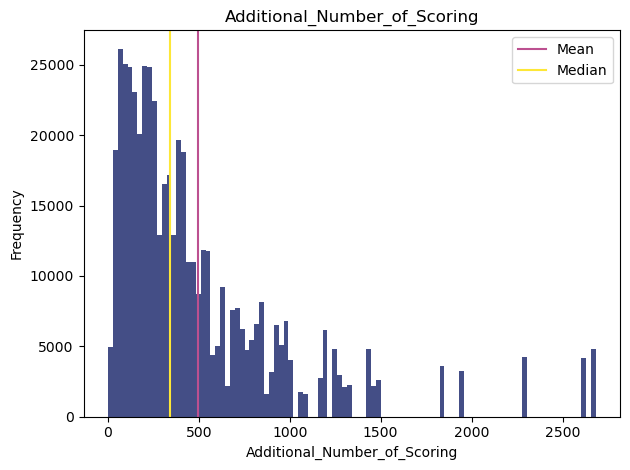

In [13]:
plt.figure()

plt.hist(data_raw['Additional_Number_of_Scoring'], bins= 100,color='#444e86')
plt.title('Additional_Number_of_Scoring')
plt.xlabel('Additional_Number_of_Scoring')
plt.ylabel('Frequency')
plt.axvline(data_raw['Additional_Number_of_Scoring'].mean(), c = '#bc5090', label = 'Mean')
plt.axvline(data_raw['Additional_Number_of_Scoring'].median(), c ='#FDE737', label = "Median")
plt.legend()

plt.tight_layout()
plt.show()

We simply regard the column as additional scoring information and stop the analysis at this point. 

In [14]:
data_raw.head(4)

,Additional_Number_of_Scoring,Average_Score,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Days_Since_Review,Latitude,Longitude,Day,Month,Year,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
0,194,7.7,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,0,0,52.360576,4.915968,3,8,2017,0,0,0,0,0,1,1,0,0,0,0,0,1,6
1,194,7.7,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,0,0,52.360576,4.915968,3,8,2017,0,1,0,0,0,0,1,0,0,0,0,0,1,4
2,194,7.7,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,0,3,52.360576,4.915968,31,7,2017,1,0,0,0,0,0,1,0,0,0,0,0,1,3
3,194,7.7,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,0,3,52.360576,4.915968,31,7,2017,0,0,0,1,0,0,1,0,0,0,0,0,1,3


In [15]:
#Testing the negative reviews

import string
random_test = list(np.random.choice(range(1, 515737), size=35, replace=False))

for i in random_test:
    s1 = data_raw.loc[i,['Negative_Review']].item()
    if len(s1.split(' ')) == data_raw.loc[i,['Review_Total_Negative_Word_Counts']].item():
        continue # skip columns with a review or no difference between count and sentence 
    else:
        a = len(s1.split(' '))-data_raw.loc[i,['Review_Total_Negative_Word_Counts']].item()
        value = data_raw.loc[i,['Negative_Review']].item()
        print(f'subtraction: {a} and value: {value}')



subtraction: 2 and value: No Negative
subtraction: 2 and value: No Negative
subtraction: 2 and value: No Negative
subtraction: 2 and value: No Negative
subtraction: 2 and value: No Negative
subtraction: 2 and value: No Negative
subtraction: 2 and value: No Negative
subtraction: 2 and value: No Negative
subtraction: 2 and value: No Negative
subtraction: 2 and value: No Negative


The column ‘Review_Total_Negative_Word_Counts’ counts the number of values: The expression No Negative means that no negative comment was entered in the questionnaire. 

In [16]:
# sanity check fpr Positive_review

random_test = list(np.random.choice(range(1, 515737), size=35, replace=False))

for i in random_test:
    s1 = data_raw.loc[i,['Positive_Review']].item()
    if len(s1.split(' ')) == data_raw.loc[i,['Review_Total_Positive_Word_Counts']].item():
        continue
    else:
        a = len(s1.split(' '))-data_raw.loc[i,['Review_Total_Positive_Word_Counts']].item()
        value = data_raw.loc[i,['Positive_Review']].item()
        print(f'subtraction: {a} and value: {value}')

subtraction: 2 and value: No Positive
subtraction: 2 and value: No Positive


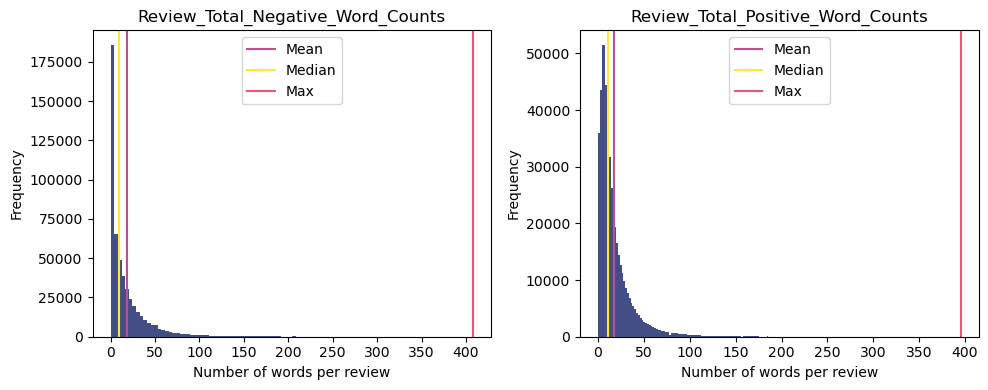

number of no negative/ empty text fields reviews: 127890, number of no positive/ empty text fields reviews: 35946


In [17]:

a = (data_raw['Review_Total_Negative_Word_Counts']== 0).sum()
b = (data_raw['Review_Total_Positive_Word_Counts']== 0).sum()

plt.subplots(1,2, figsize = (10,4))

plt.subplot(1,2,1)
plt.hist(data_raw['Review_Total_Negative_Word_Counts'], bins= 100,color='#444e86')
plt.title('Review_Total_Negative_Word_Counts')
plt.xlabel('Number of words per review')
plt.axvline(data_raw['Review_Total_Negative_Word_Counts'].mean(), c = '#bc5090', label = 'Mean')
plt.axvline(data_raw['Review_Total_Negative_Word_Counts'].median(), c ='#FDE737', label = "Median")
plt.axvline(data_raw['Review_Total_Negative_Word_Counts'].max(),c ='#ef5675', label = 'Max')
plt.ylabel('Frequency')
plt. legend(loc='upper center')

plt.subplot(1,2,2)
plt.hist(data_raw['Review_Total_Positive_Word_Counts'], bins= 200,color='#444e86')
plt.title('Review_Total_Positive_Word_Counts')
plt.xlabel('Number of words per review')
plt.axvline(data_raw['Review_Total_Positive_Word_Counts'].mean(), c = '#bc5090', label = 'Mean')
plt.axvline(data_raw['Review_Total_Positive_Word_Counts'].median(), c ='#FDE737', label = "Median")
plt.axvline(data_raw['Review_Total_Positive_Word_Counts'].max(),c ='#ef5675', label = 'Max')
plt.ylabel('Frequency')

plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

print(f'number of no negative/ empty text fields reviews: {a}, number of no positive/ empty text fields reviews: {b}')


In [18]:
data_raw['Review_Total_Positive_Word_Counts'].mean()

17.77645820164502

We can conclude from this that the willingness to make a written statement is higher when positive feedback is given. In the case of negative feedback, more precise details are often not given. 

The connection between text and Review_Total_Negative/Positve_Word_Counts and Positive/Negative_Review is clear, the confusion was caused by the statement No Negative/No Positive.

#### Creating of the clean dataframe

In [19]:
print(c)

['Additional_Number_of_Scoring', 'Average_Score', 'Negative_Review', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Positive_Review', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Days_Since_Review', 'Latitude', 'Longitude', 'Day', 'Month', 'Year', 'Reviewer_Nationality_Australia', 'Reviewer_Nationality_Ireland', 'Reviewer_Nationality_UAE', 'Reviewer_Nationality_UK', 'Reviewer_Nationality_USA', 'Reviewer_Nationality_Other', 'Hotel_Address_Amsterdam', 'Hotel_Address_Barcelona', 'Hotel_Address_London', 'Hotel_Address_Milan', 'Hotel_Address_Paris', 'Hotel_Address_Vienna', 'Leisure_Trip', 'Nights_Stayed']


In [20]:
data = data_raw[[
    c[8], # target column
    c[2],c[5], # Reviews
    c[3],c[6],c[27],c[28],c[9],c[12],c[13],c[14],c[0],c[15],c[16],c[17],c[18],c[19],c[20],c[7], #Review adddition information columns
    c[1],c[4],c[21],c[22],c[23],c[24],c[25],c[26],c[10],c[11] #Hotel information columns 
]]

In [21]:
data.head(3)

,Reviewer_Score,Negative_Review,Positive_Review,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Leisure_Trip,Nights_Stayed,Days_Since_Review,Day,Month,Year,Additional_Number_of_Scoring,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Total_Number_of_Reviews_Reviewer_Has_Given,Average_Score,Total_Number_of_Reviews,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Latitude,Longitude
0,0,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,397,11,1,6,0,3,8,2017,194,0,0,0,0,0,1,7,7.7,1403,1,0,0,0,0,0,52.360576,4.915968
1,0,No Negative,No real complaints the hotel was great great ...,0,105,1,4,0,3,8,2017,194,0,1,0,0,0,0,7,7.7,1403,1,0,0,0,0,0,52.360576,4.915968
2,0,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,42,21,1,3,3,31,7,2017,194,1,0,0,0,0,0,9,7.7,1403,1,0,0,0,0,0,52.360576,4.915968


#### Exploration 

Combine the days, months and years into one column and remove the individual columns (day, month, year).

In [22]:
pd.to_datetime(data[['Year', 'Month', 'Day']]).min()

Timestamp('2015-08-04 00:00:00')

In [23]:
data.insert(8, 'Date', pd.to_datetime(data[['Year', 'Month', 'Day']]))

In [24]:
data = data.drop(columns=['Day', 'Month', 'Year'] ,axis=1)

In [25]:
data.duplicated().sum()

539

In [26]:
data[data.duplicated(keep=False)].head(4)

,Reviewer_Score,Negative_Review,Positive_Review,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Leisure_Trip,Nights_Stayed,Days_Since_Review,Date,Additional_Number_of_Scoring,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Total_Number_of_Reviews_Reviewer_Has_Given,Average_Score,Total_Number_of_Reviews,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Latitude,Longitude
22083,1,Nothing,Good Service,2,3,0,4,0,2017-08-03,83,0,0,0,0,0,1,5,8.3,549,0,0,0,0,1,0,48.849143,2.339712
22084,1,Nothing,Good Service,2,3,0,4,0,2017-08-03,83,0,0,0,0,0,1,5,8.3,549,0,0,0,0,1,0,48.849143,2.339712
23703,1,none,good location and super nice staff room is bi...,2,13,0,1,159,2017-02-25,728,0,0,0,0,0,1,39,8.9,3168,0,0,1,0,0,0,51.528677,-0.128349
23704,1,none,good location and super nice staff room is bi...,2,13,0,1,159,2017-02-25,728,0,0,0,0,0,1,39,8.9,3168,0,0,1,0,0,0,51.528677,-0.128349


To analyse the duplicates, it is important to exclude the columns of the hotel. These are not a criterion for distinguishing a real duplicate from a random one. A duplicate dataframe is therefore created. 

In [27]:
duplicate = data[data.duplicated(keep = False)].loc[:, 'Negative_Review':'Total_Number_of_Reviews_Reviewer_Has_Given']

The indexing is retained by the loc function. We now check how many ‘real duplicates’ are retained if the hotel criteria are not taken into account.

In [28]:
duplicate.duplicated().sum()

539

539 = 539, this means that the hotel details were not a reason for the duplicate. Now let's take a closer look at the answers.

In [29]:
duplicate.head(10)

,Negative_Review,Positive_Review,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Leisure_Trip,Nights_Stayed,Days_Since_Review,Date,Additional_Number_of_Scoring,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Total_Number_of_Reviews_Reviewer_Has_Given
22083,Nothing,Good Service,2,3,0,4,0,2017-08-03,83,0,0,0,0,0,1,5
22084,Nothing,Good Service,2,3,0,4,0,2017-08-03,83,0,0,0,0,0,1,5
23703,none,good location and super nice staff room is bi...,2,13,0,1,159,2017-02-25,728,0,0,0,0,0,1,39
23704,none,good location and super nice staff room is bi...,2,13,0,1,159,2017-02-25,728,0,0,0,0,0,1,39
61875,No Negative,The attention received by Sebastian and his t...,0,12,1,2,7,2017-07-27,300,0,0,0,0,0,1,4
61876,No Negative,The attention received by Sebastian and his t...,0,12,1,2,7,2017-07-27,300,0,0,0,0,0,1,4
68936,Location is very old not invested in past yea...,Location is central accessible by train parki...,41,12,0,1,41,2017-06-23,11,0,0,0,0,0,1,24
68937,This hotel I don t think so is 4 star B B hav...,Nothing,93,2,0,1,98,2017-04-27,11,0,0,0,1,0,0,10
68938,The staff were not helpful at all It took us ...,Near bus terminal,69,4,1,4,152,2017-03-04,11,0,0,0,0,0,1,4
68939,We booked hotel for 3 nights and there was no...,Good place,39,4,0,3,287,2016-10-20,11,0,0,0,0,0,1,9


The duplicates appear to be real duplicates, even if they do not always appear at consecutive index positions. The duplicates are therefore deleted in data.

In [30]:
data = data.drop_duplicates(keep='first')

In [31]:
data.duplicated().sum()

0

Check for missing data: 

In [32]:
data.isna().sum()

Reviewer_Score                                0
Negative_Review                               0
Positive_Review                               0
Review_Total_Negative_Word_Counts             0
Review_Total_Positive_Word_Counts             0
Leisure_Trip                                  0
Nights_Stayed                                 0
Days_Since_Review                             0
Date                                          0
Additional_Number_of_Scoring                  0
Reviewer_Nationality_Australia                0
Reviewer_Nationality_Ireland                  0
Reviewer_Nationality_UAE                      0
Reviewer_Nationality_UK                       0
Reviewer_Nationality_USA                      0
Reviewer_Nationality_Other                    0
Total_Number_of_Reviews_Reviewer_Has_Given    0
Average_Score                                 0
Total_Number_of_Reviews                       0
Hotel_Address_Amsterdam                       0
Hotel_Address_Barcelona                 

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515199 entries, 0 to 515737
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Reviewer_Score                              515199 non-null  int64         
 1   Negative_Review                             515199 non-null  object        
 2   Positive_Review                             515199 non-null  object        
 3   Review_Total_Negative_Word_Counts           515199 non-null  int64         
 4   Review_Total_Positive_Word_Counts           515199 non-null  int64         
 5   Leisure_Trip                                515199 non-null  int64         
 6   Nights_Stayed                               515199 non-null  int64         
 7   Days_Since_Review                           515199 non-null  int64         
 8   Date                                        515199 non-null  datetime64[ns]
 9 

To make sure, that the index is equal to the row number we reset the index and safe the dataset 

In [34]:
data = data.reset_index(drop= True)

In [35]:
data.describe()

,Reviewer_Score,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Leisure_Trip,Nights_Stayed,Days_Since_Review,Date,Additional_Number_of_Scoring,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Total_Number_of_Reviews_Reviewer_Has_Given,Average_Score,Total_Number_of_Reviews,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Latitude,Longitude
count,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000
mean,0.570100,18.540711,17.778489,0.810070,2.361750,354.402120,2016-08-13 14:20:56.802129152,498.417604,0.042019,0.028754,0.019853,0.475752,0.068612,0.365010,7.164750,8.397776,2744.691424,0.111043,0.116747,0.509110,0.072209,0.115319,0.075573,49.433012,2.893915
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2015-08-04 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.200000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.328376,-0.369758
25%,0.000000,2.000000,5.000000,1.000000,1.000000,175.000000,2016-02-23 00:00:00,169.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.100000,1161.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.214066,-0.143372
50%,1.000000,9.000000,11.000000,1.000000,2.000000,353.000000,2016-08-15 00:00:00,342.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,8.400000,2134.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,51.499981,0.019886
75%,1.000000,23.000000,22.000000,1.000000,3.000000,527.000000,2017-02-09 00:00:00,660.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,8.000000,8.800000,3633.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,51.516288,4.841163
max,1.000000,408.000000,395.000000,1.000000,31.000000,730.000000,2017-08-03 00:00:00,2682.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,355.000000,9.800000,16670.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,52.400181,16.429233
std,0.495062,29.693602,21.804665,0.392246,1.646734,208.909135,NaN,500.673193,0.200632,0.167114,0.139494,0.499412,0.252794,0.481434,11.039315,0.547947,2318.112418,0.314185,0.321119,0.499917,0.258834,0.319406,0.264314,3.461933,4.669672


Of the 515,199 reviews, 293,715 or 57% are positive. On average, a negative review is slightly longer than a positive one. 81% or 417,347 of the trips reviewed were leisure trips. The average length of these trips was 2.3 nights.

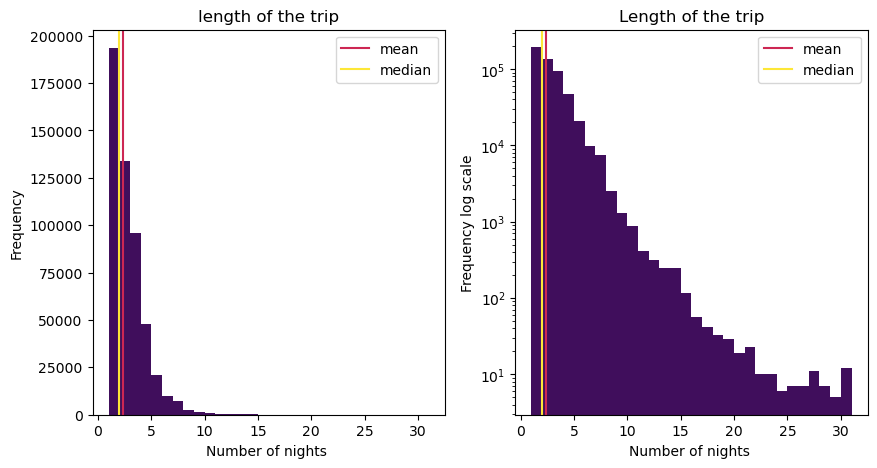

In [36]:
plt.subplots(1,2, figsize= (10,5))
plt.subplot(1,2,1)
plt.hist(data['Nights_Stayed'], bins = 30 ,color ='#400e5c')
plt.axvline(data['Nights_Stayed'].mean(), label='mean', color = '#cd2753')
plt.axvline(data['Nights_Stayed'].median(), label = 'median', color = '#FDE737')
plt.legend()
plt.title('length of the trip')
plt.ylabel('Frequency')
plt.xlabel('Number of nights ')

plt.subplot(1,2,2)
plt.hist(data['Nights_Stayed'], bins = 30 ,color ='#400e5c')
plt.axvline(data['Nights_Stayed'].mean(), label='mean', color = '#cd2753')
plt.axvline(data['Nights_Stayed'].median(), label = 'median', color = '#FDE737')
plt.legend()
plt.yscale('log') #to visualize the values between ~10 and 30 days
plt.title('Length of the trip')
plt.ylabel('Frequency log scale')
plt.xlabel('Number of nights ')
plt.show()

The majority of the reviews include short stays and not week-long holidays. 

In [37]:
data.head(1)

,Reviewer_Score,Negative_Review,Positive_Review,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Leisure_Trip,Nights_Stayed,Days_Since_Review,Date,Additional_Number_of_Scoring,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Total_Number_of_Reviews_Reviewer_Has_Given,Average_Score,Total_Number_of_Reviews,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Latitude,Longitude
0,0,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,397,11,1,6,0,2017-08-03,194,0,0,0,0,0,1,7,7.7,1403,1,0,0,0,0,0,52.360576,4.915968


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515199 entries, 0 to 515198
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Reviewer_Score                              515199 non-null  int64         
 1   Negative_Review                             515199 non-null  object        
 2   Positive_Review                             515199 non-null  object        
 3   Review_Total_Negative_Word_Counts           515199 non-null  int64         
 4   Review_Total_Positive_Word_Counts           515199 non-null  int64         
 5   Leisure_Trip                                515199 non-null  int64         
 6   Nights_Stayed                               515199 non-null  int64         
 7   Days_Since_Review                           515199 non-null  int64         
 8   Date                                        515199 non-null  datetime64[ns

In [39]:
A = data.loc[data['Hotel_Address_Amsterdam']==1]['Reviewer_Score'].mean()*100
B = data.loc[data['Hotel_Address_Barcelona']==1]['Reviewer_Score'].mean()*100
L = data.loc[data['Hotel_Address_London']==1]['Reviewer_Score'].mean()*100
M = data.loc[data['Hotel_Address_Milan']==1]['Reviewer_Score'].mean()*100
P = data.loc[data['Hotel_Address_Paris']==1]['Reviewer_Score'].mean()*100
V = data.loc[data['Hotel_Address_Vienna']==1]['Reviewer_Score'].mean()*100

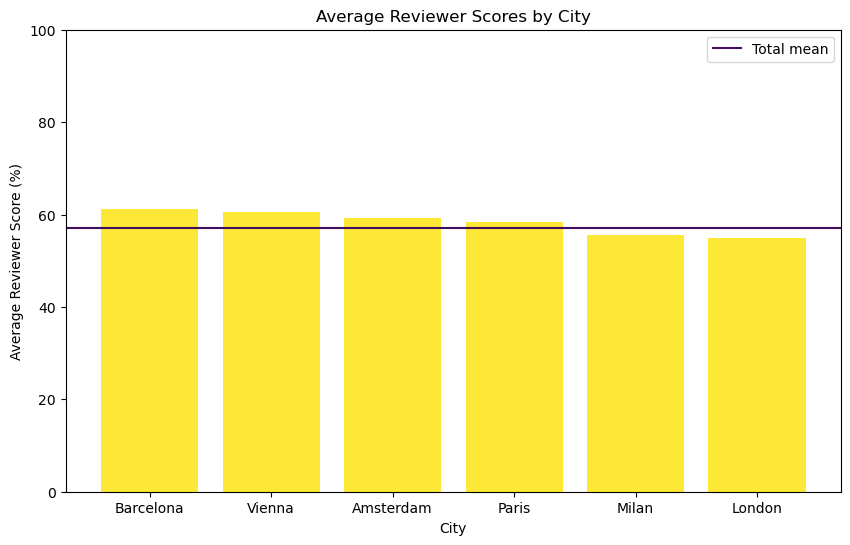

In [40]:
scores = {
    'Barcelona': B,
    'Vienna': V,
    'Amsterdam': A,
    'Paris': P,
    'Milan': M,
    'London': L
}
df_scores = pd.DataFrame(list(scores.items()), columns=['City', 'Average Reviewer Score']) # create a dataframe for visualization

plt.figure(figsize=(10, 6))
plt.bar(df_scores['City'], df_scores['Average Reviewer Score'], color='#FDE737')
plt.xlabel('City')
plt.ylabel('Average Reviewer Score (%)')
plt.title('Average Reviewer Scores by City')
plt.ylim(0, 100)
plt.axhline(y= data['Reviewer_Score'].mean()*100, color='#400e5c', label = 'Total mean')
plt.legend()
plt.show()

Hotel guest satisfaction varies from city to city. Overall, hotel guests in Vienna and Barcelona are more satisfied than those in London and Milan. These cities underperform in terms of customer satisfaction. 

In [41]:
from matplotlib.lines import Line2D
colors = data['Reviewer_Score'].map({0:'#003f5c', 1:'#FDE737'})

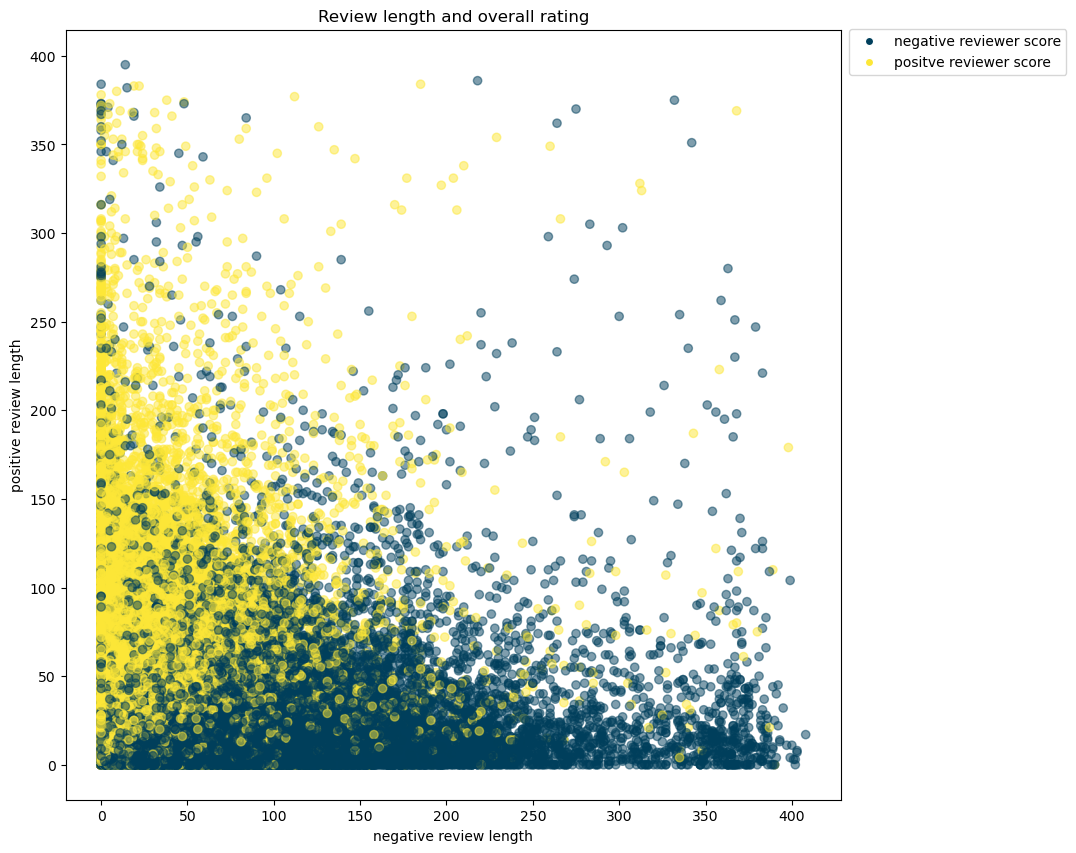

In [42]:
plt.figure(figsize=(10,10))
plt.scatter(x=data['Review_Total_Negative_Word_Counts'],y=data['Review_Total_Positive_Word_Counts'], color = colors, alpha= 0.5)
plt.ylabel('positive review length')
plt.xlabel('negative review length')

custom_lines = [Line2D([0], [0], color='w',markerfacecolor='#003f5c',marker='o', lw=2, label = 'negative reviewer score'),
                Line2D([0], [0], color='w',markerfacecolor='#FDE737',marker='o', lw=2,label = 'positve reviewer score')]

plt.title('Review length and overall rating')
plt.legend(handles= custom_lines, loc ='upper right', bbox_to_anchor=(1.30, 1.01))
plt.show()

Sources:          
https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html#pandas.Series.map            
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html           
https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html#sphx-glr-gallery-text-labels-and-annotations-custom-legends-py           

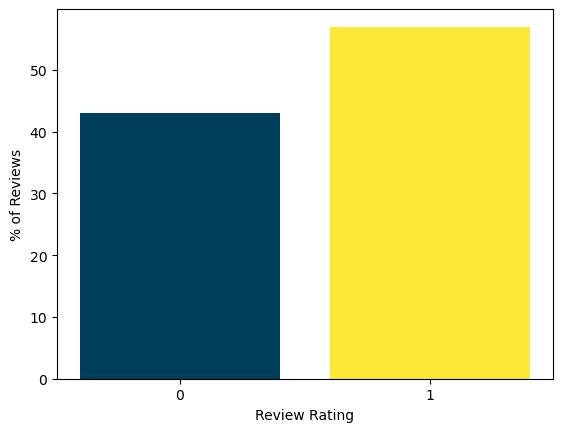

Class imbalance: [0.4299 0.5701]


In [43]:
values, counts = np.unique(data['Reviewer_Score'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100, color = ['#003f5c','#FDE737'])
plt.xlabel('Review Rating')
plt.ylabel('% of Reviews')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 4)}")

We see a correlation between the length of the positive and negative statements and the reviewer's overall rating. If both texts, i.e. the positive and the negative text, are approximately the same length, there seems to be a tendency to mark the overall experience as positive (yellow). The respective extreme ranges are interesting. For example, there are reviewers who write long positive texts and short negative texts and still give a negative overall rating. The total length of a review therefore does not have an absolute influence on the result. The correlation is examined below

### 4.2 Preprocessing


First, create a dataframe which only contains the columns of 'intrest' - e.g. the review texts and the reviewer score.

In [44]:
reviews = data.loc[:,['Reviewer_Score','Negative_Review','Positive_Review']]

In [45]:
from sklearn.model_selection import train_test_split

Split our dataframe reviews into a test and a train set

In [46]:
y = reviews['Reviewer_Score']
X = reviews[['Negative_Review','Positive_Review']]

In [47]:
split = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=49, stratify=y)


Now we split X_train and X_test in X_train_neg/ X_train_pos and X_test_neg/X_test_pos for performance reasons. Let's have a look to get an better understanding. 

In [48]:
X_train.head()

,Negative_Review,Positive_Review
394529,Had stayed in 60 hotels around the world and ...,Nothing
287411,No Negative,The staffs are kind and helpful
51338,Forced to have another room as i have kids Ge...,Location
194338,Mattress was not comfortable,No Positive
175001,It would have been nice to have had some refr...,I was enchanted by the lovely homely feel at ...


X_train and X_test contain 2 columns - one for the negative and one for the positive Review text. Due to the large number of entries and in order to maintain an overview, the positive and negative reviews are saved in separate data frames. We split them. 

In [49]:
X_train_neg = X_train['Negative_Review']
X_train_pos = X_train['Positive_Review']
X_test_neg = X_test['Negative_Review']
X_test_pos = X_test['Positive_Review']

In [50]:
print(f'X_train_neg: {X_train_neg.shape}, X_train_pos: {X_train_pos.shape} and y_train:{y_train.shape}')
print(f'X_test_neg: {X_test_neg.shape}, X_test_pos: {X_test_pos.shape} and y_test: {y_test.shape}')

X_train_neg: (412159,), X_train_pos: (412159,) and y_train:(412159,)
X_test_neg: (103040,), X_test_pos: (103040,) and y_test: (103040,)


No we transform our data with a Tokenizer

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
# 1. Instantiate the tokenizer
vectorizer_pos_raw = CountVectorizer() 

# 2. fit
vectorizer_pos_raw.fit(X_train_pos)

# 3. Transform
X_train_pos_transformed = vectorizer_pos_raw.transform(X_train_pos)


In [53]:
# 1. Instantiate the tokenizer
vectorizer_neg_raw = CountVectorizer() 

# 2. fit
vectorizer_neg_raw.fit(X_train_neg)

# 3. Transform
X_train_neg_transformed = vectorizer_neg_raw.transform(X_train_neg)

Important note. Normally, the test data should also be transformed here with the corresponding Vectorizer, but since I will still be adapting it, this will only be done with the final Vectorizer_pos/_neg

We have created a sparse matrix with each of these two code blocks. Each comment was split into its words and these were created as columns in the matrix. Each word only appears once in the columns. If this word now appears in the comment, a number corresponding to the number of words in the comment is created in the corresponding row. The resulting matrices are very large (see below), so it makes sense to divide them into positive comments and negative comments.

In [54]:
X_train_pos_transformed

<412159x45691 sparse matrix of type '<class 'numpy.int64'>'
	with 5612148 stored elements in Compressed Sparse Row format>

In [55]:
X_train_neg_transformed

<412159x49622 sparse matrix of type '<class 'numpy.int64'>'
	with 5711024 stored elements in Compressed Sparse Row format>

Jetzt schauen wir uns an, welche Token der Vectorizer_pos/neg_raw erzeugt hat. 

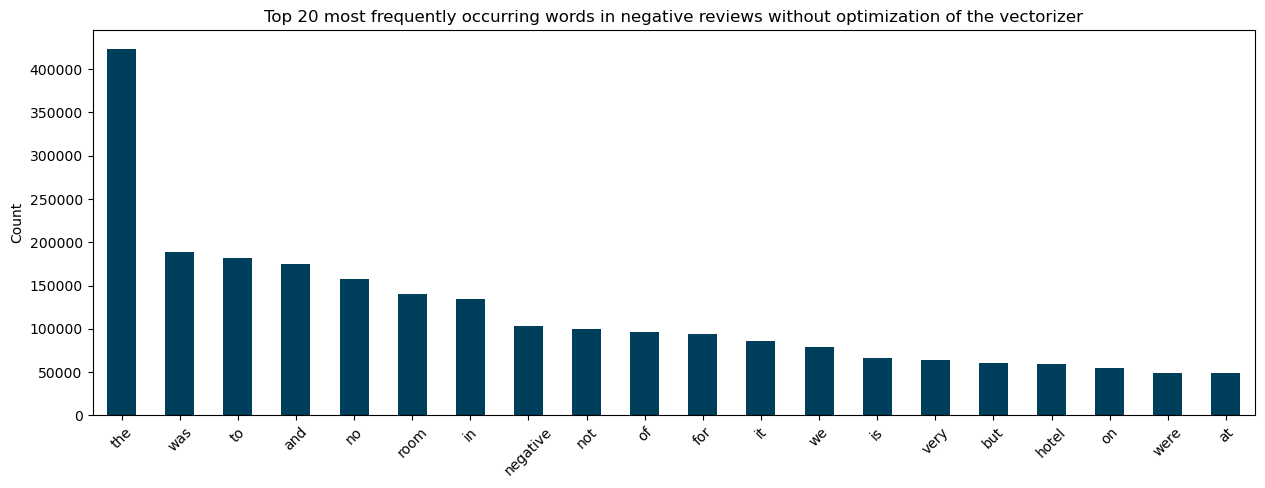

In [56]:
word_counts = pd.DataFrame(
    {"counts": X_train_neg_transformed.sum(axis=0).A1}, #alternative: .A.flatten() instead of .A1
    index=vectorizer_neg_raw.get_feature_names()
).sort_values("counts", ascending=False)

# Plotting the top 20 most frequently occurring words
word_counts.head(20).plot(kind="bar", figsize=(15, 5),color='#003f5c',  legend=False)
plt.title("Top 20 most frequently occurring words in negative reviews without optimization of the vectorizer")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

  The first approach with .toarray() wasn't working because of memory issues. I had to look up an alternative.  Using the .A1 to flatten the matrix inplace instead of creating an array. Somehow CountVectorizer' object has no attribute 'get_feature_names_out' - I use the get_feature_names instead. 


Sources:
https://stackoverflow.com/questions/73415826/          how-to-covert-a-large-106-106-numpy-sparse-matrix-to-a-scipy-sparse-matrix
https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


We will now reduce the total number of tokens. We can see above that many words in the top 20 of the train_neg data example have no meaning. It can also be assumed that many words in the 412159x49514 matrix have no meaning and only cost memory space. Therefore, the CountVectoriser() method is extended by parameters and a function:

#### Finetuning of the transformer CountVectorizer

The above summarisation of the occurring tokens, sorted by descending frequency, reveals that many tokens do not suggest a statement in terms of content. This applies to the 5 most frequent tokens:
- the
- was
- to
- and 
- no 

To eliminate the influence of these meaningless tokens on our model and reduce the number of tokens from 49514 to a manageable quantity, the CountVectorizer() transformer is adapted accordingly to **a) reduce the quantity output, b) enrich its quality and thus c) improve the model.**

The transformer is refined with the following parameters. 

CountVectorizer(       
	**- stop_words='english,**       --> This retrieves a predefined list of all known English prepositions, articles and filler words such as ‘the’ ‘has’ etc. and excludes them.     
                				**- tokenizer = custom_tokenizer,**          -->  This is an additional defined function that excludes another word group.                 
 								**- min_df =10,**          --> we reduce the minimum frequency of a token = word to 10. this exclusion drastically reduces the total number without losing much precision                                   
 								**- max_features =500,** --> We reduce the number of tokens to 500 in descending order from the most frequent. These tokens have the greatest influence             
 								**- ngram_range=(1, 3)** --> We consider not only individual words, but also groups of words <very happy> that are also subject to the frequency criteria          
								)           

#### Fitting the vectorizer

Die Kriterien werden für beide Vectorizer angewendet, also sowhol für die positiven als auch die negativen Review token

In [57]:
# #1. Instantiate the tokenizer for our positive reviews
# vectorizer_pos = CountVectorizer(stop_words='english',
# 								tokenizer = custom_tokenizer, 
# 								min_df =10, # the minimum occurance of a word in 5 reviews 
# 								max_features =500, #we limit the number of tokens to 1500
# 								ngram_range=(1, 3)) # to explode the features we include word combinations in this case: 2 words. for example: very good instead of very and good.

# # 2. fit
# vectorizer_pos.fit(X_train_pos)


In [58]:
# #1. Instantiate the tokenizer for the negative reviews
# vectorizer_neg = CountVectorizer(stop_words='english',
# 								tokenizer = custom_tokenizer, 
# 								min_df =10, 
# 								max_features =500, 
# 								ngram_range=(1, 3)) # good in combination with min_df to get rid of useless pairs

# # 2. fit
# vectorizer_neg.fit(X_train_neg)


Because of the long runtime, I only run this code once. Then I saved my customized transformers in ./models

In [59]:
import joblib

In [60]:
# joblib.dump(vectorizer_pos, './models/vectorizer_pos.pkl')

In [61]:
# joblib.dump(vectorizer_neg, './models/vectorizer_neg.pkl')

#### Reload the fitted vectorizer 

These are the transformers created with the Trinings data. These now each contain the 500 most frequently filtered tokens from the positive and negative reviews 

In [62]:
vectorizer_pos = joblib.load('./models/vectorizer_pos.pkl')
vectorizer_neg = joblib.load('./models/vectorizer_neg.pkl')


#### Transformation of our X_tests (neg/pos) and X_train(neg/pos) with our CountVectorizers

We still have to apply the transformiser that we created using X_train to X_train and X_test for both positive and negative values.

We transform the X_test_neg/X_test_pos. But we use the fitted transformer from our training data. Therefore, any word that is in our test set and not in our train set will be ignored because the sparse matrix has no corresponding column

In [63]:
# # 3. Transform
# X_train_pos_transformed = vectorizer_pos.transform(X_train_pos)
# X_test_pos_transformed = vectorizer_pos.transform(X_test_pos)

# X_train_neg_transformed = vectorizer_neg.transform(X_train_neg)
# X_test_neg_transformed = vectorizer_neg.transform(X_test_neg)

We safe this matrices...

In [64]:
# sp.sparse.save_npz('./models/X_train_pos_transformed.npz',X_train_pos_transformed)
# sp.sparse.save_npz('./models/X_train_neg_transformed.npz',X_train_neg_transformed)
# sp.sparse.save_npz('./models/X_test_neg_transformed.npz',X_test_neg_transformed)
# sp.sparse.save_npz('./models/X_test_pos_transformed.npz',X_test_pos_transformed)

Visualization of the process above

|              |             |             |         |               |               |            |            |        |        |                |
|--------------|-------------|-------------|---------|---------------|---------------|------------|------------|--------|--------|----------------|
|   Review ID  | **Token 1** | **Token 2** | **...** | **Token 499** | **Token 500** |  Token 501 |  Token 502 |   ...  |   ...  |   Token 49514  |
|    1_train   |    **1**    |    **2**    | **...** |     **1**     |     **1**     |      -     |      -     |    -   |    -   |        -       |
|    3_train   |    **0**    |    **0**    | **...** |     **0**     |     **1**     |      -     |      -     |    -   |    -   |        -       |
|    4_train   |    **2**    |    **1**    | **...** |     **0**     |     **0**     |      -     |      -     |    -   |    -   |        -       |
|    5_train   |    **1**    |    **0**    | **...** |     **1**     |     **1**     |      -     |      -     |    -   |    -   |        -       |
|      ...     |             |             | **...** |               |               |            |            |        |        |                |
| **--------** | ----------  | ------      | ------- | --------      | -------       | **------** | **------** | **--** | **--** | **----------** |
| test_12      | **0**       | **0**       | **...** | **0**         | **0**         |      -     |      -     |    -   |    -   |        -       |
| test_15      | **0**       | **3**       | **...** | **1**         | **0**         |      -     |      -     |    -   |    -   |        -       |
|      ...     |             |             |         |               |               |            |            |        |        |                |


We have created the transformer for the negative reviews with the help of our X_test_pos test set. This means that we have defined the tokens 1 to 500 based on their frequency and the criteria described above. Now we use this transformer to convert our data set X_train_pos and X_test_pos into these tokens. This means that the reviews in X_train_neg are first converted into token totals. Only tokens that were in the transformer are counted. The original 49514 tokens are not recorded and are only shown here to illustrate that this information (which is stored in these tokens) is not included in our model. The same happens with the test data X_test_pos, here it is special that this data had no influence on the Transformer (the selection of the 500 tokens) and therefore may have a lower match. 

For example, a positive comment in another language would have no influence on the model, despite its high informative value, as no token in the comment would have matched the 500 of the transformer.

The resulting matrices contain many zeros and little information (numbers) per line. These sparse matrices are also saved after they are created.

#### Reloading of our safed and transformed sparse matrices

In [65]:
X_train_pos_transformed = sp.sparse.load_npz('./models/X_train_pos_transformed.npz')
X_train_neg_transformed = sp.sparse.load_npz('./models/X_train_neg_transformed.npz')
X_test_neg_transformed = sp.sparse.load_npz('./models/X_test_neg_transformed.npz')
X_test_pos_transformed = sp.sparse.load_npz('./models/X_test_pos_transformed.npz')

In [66]:
print(X_train_pos_transformed.shape)
print(X_train_neg_transformed.shape)
print(X_test_neg_transformed.shape)
print(X_test_pos_transformed.shape)

(412159, 500)
(412159, 500)
(103040, 500)
(103040, 500)


#### Visualization of the sparce matrices

In [67]:
word_counts_neg = pd.DataFrame(
    {"counts": X_train_neg_transformed.sum(axis=0).A1}, #alternative: .A.flatten() instead of .A1
    index=vectorizer_neg.get_feature_names()
).sort_values("counts", ascending=False)

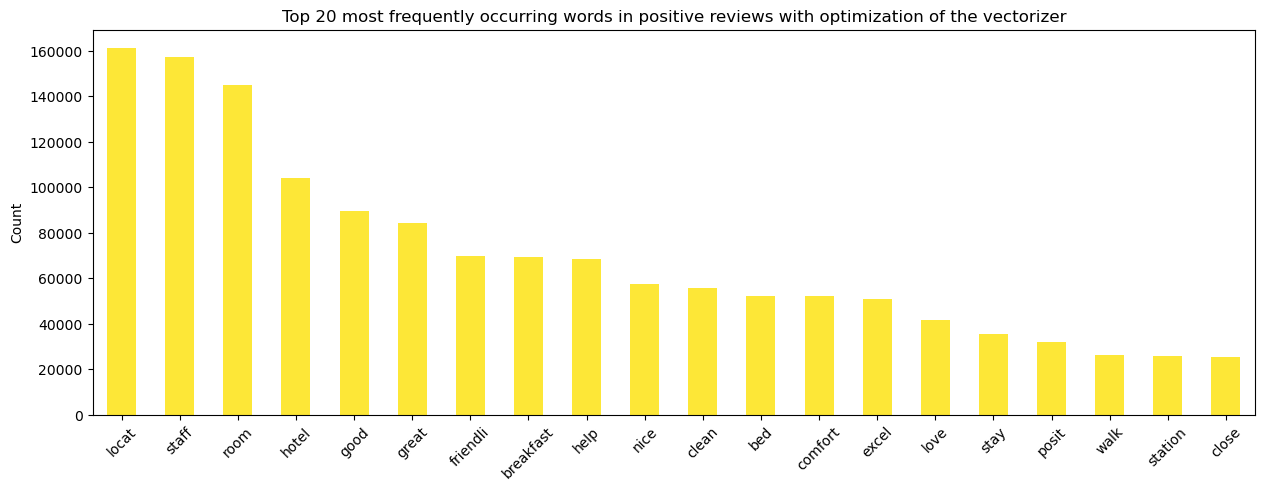

In [68]:
word_counts_pos = pd.DataFrame(
    {"counts": X_train_pos_transformed.sum(axis=0).A1}, #alternative: .A.flatten() instead of .A1
    index=vectorizer_pos.get_feature_names()
).sort_values("counts", ascending=False)

# Plotting the top 20 most frequently occurring words
word_counts_pos.head(20).plot(kind="bar", figsize=(15, 5),color='#FDE737',  legend=False)
plt.title("Top 20 most frequently occurring words in positive reviews with optimization of the vectorizer")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

We now see that we have a more precise selection of words that give an indication of the reviewer's state of mind and we therefore have a quality-enriched sparse matrix. 

#### Prepartation of the concating of the matrices 

In order to link the information in both matrices, the assignment of the token must be maintained. For this purpose, the tokens are provided with a corresponding origin-indicating prefix.

In [69]:
token_neg = vectorizer_neg.get_feature_names()
new_vocab_neg = ["neg_" + token for token in token_neg]
vocab_mapping_neg = {old: new for old, new in zip(token_neg, new_vocab_neg)}

# renamed matrix
X_train_neg_transformed = rename_tokens(X_train_neg_transformed, vocab_mapping_neg, token_neg)

In [70]:
X_train_neg_transformed.shape

(412159, 500)

In [71]:
token_pos = vectorizer_pos.get_feature_names()
new_vocab_pos = ["pos_" + token for token in token_pos]

vocab_mapping_pos = {old: new for old, new in zip(token_pos, new_vocab_pos)}

#renamed matrix
X_train_pos_transformed = rename_tokens(X_train_pos_transformed, vocab_mapping_pos, token_pos)

In [72]:
X_train_pos_transformed.shape

(412159, 500)

Sanity check:

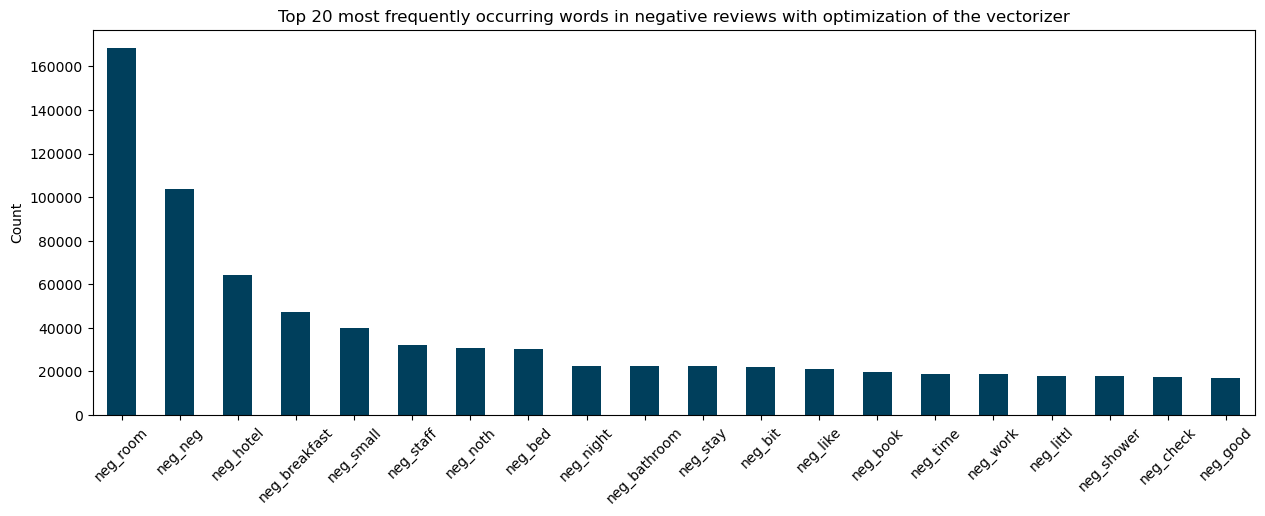

In [73]:
word_counts_neg = pd.DataFrame(
    {"counts": X_train_neg_transformed.sum(axis=0).A1}, #alternative: .A.flatten() instead of .A1
    index=new_vocab_neg
).sort_values("counts", ascending=False)

# Plotting the top 20 most frequently occurring words
word_counts_neg.head(20).plot(kind="bar", figsize=(15, 5),color='#003f5c',  legend=False)
plt.title("Top 20 most frequently occurring words in negative reviews with optimization of the vectorizer")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

We now have an attribute neg_ or pos_ in front of each token as an indication of origin

In [74]:
X_train_neg

394529     Had stayed in 60 hotels around the world and ...
287411                                          No Negative
51338      Forced to have another room as i have kids Ge...
194338                        Mattress was not comfortable 
175001     It would have been nice to have had some refr...
                                ...                        
106325                    No flexibility in check out time 
328818                         No airport transfers at all 
176846                                          No Negative
134362                                          No Negative
24164                                              Nothing 
Name: Negative_Review, Length: 412159, dtype: object

In [75]:
word_counts_pos = pd.DataFrame(
    {"counts": X_train_pos_transformed.sum(axis=0).A1}, #alternative: .A.flatten() instead of .A1
    index=new_vocab_pos
).sort_values("counts", ascending=False)


#### Concating train and test

Now we join the two matrices to get our train and test data sets.

In [76]:
X_train_neg_df = pd.DataFrame(X_train_neg_transformed.toarray(), columns=new_vocab_neg, index=X_train_neg.index)
X_train_pos_df = pd.DataFrame(X_train_pos_transformed.toarray(), columns=new_vocab_pos, index= X_train_pos.index)
X_train_df = pd.concat([X_train_pos_df, X_train_neg_df], axis= 1  )

In [77]:
X_test_neg_df = pd.DataFrame(X_test_neg_transformed.toarray(), columns=new_vocab_neg, index=X_test_neg.index)
X_test_pos_df = pd.DataFrame(X_test_pos_transformed.toarray(), columns=new_vocab_pos, index= X_test_pos.index)
X_test_df = pd.concat([X_test_pos_df, X_test_neg_df], axis= 1  )

#### Sanity checks 

In [78]:
print(f'Number of Nall Values in X_test: {X_test_df.isna().sum().sum()}')
print(f'Number of Nall Values in X_train: {X_train_df.isna().sum().sum()}')
print(f'Shape of X_test: {X_test_df.shape}')
print(f'Shape of X_train: {X_train_df.shape}')

print('All looks good so far..')

Number of Nall Values in X_test: 0
Number of Nall Values in X_train: 0
Shape of X_test: (103040, 1000)
Shape of X_train: (412159, 1000)
All looks good so far..


The number of tokens has now doubled from 500 to 1000 (500 neg and 500 pos), no Nal Values

This loop checks whether the index in Test is also present in Train. If this is the case, the connection of the matrices has not worked. The other two loops compare the indexes between the x-values and the y-values

In [79]:
# first check: is there an index in X_train and in X_test
 
index_X_train = X_train_df.index
for i in index_X_train:
    if  i not in X_test_df.index:
        continue
    else:
        print(i)

# secound check: for every index in my y_test is there an index in X_test

index_test_test = y_test.index
for i in index_test_test:
    if  i in X_test_df.index:
        continue
    else:
        print(i)

# third check: for every index in my y_train is there an index in X_train

index_train_test = y_train.index
for i in index_train_test:
    if  i in X_train_df.index:
        continue
    else:
        print(i)


looks good

In [80]:
X_test_df.sample(3).T


,111633,196215,118511
pos_1,0,0,0
pos_10,0,0,0
pos_10 minut,0,0,0
pos_15,0,0,0
pos_2,0,0,0
...,...,...,...
neg_worn,0,0,0
neg_worst,0,0,0
neg_worth,0,0,0
neg_wrong,0,0,0


In [81]:
X_train_df.sample(3).T

,207955,159176,58186
pos_1,0,0,0
pos_10,0,0,0
pos_10 minut,0,0,0
pos_15,0,0,0
pos_2,0,0,0
...,...,...,...
neg_worn,0,0,0
neg_worst,0,0,0
neg_worth,0,0,0
neg_wrong,0,0,0


### 4.3 Logistic regression model


In order to build a model that predicts the overall recommendation based on the comments in the positive review and negative review columns, we first create a logistic model.


In [82]:
# logreg_model_wO = LogisticRegression(max_iter= 1000, random_state= 123)

# logreg_model_wO.fit(X_train_df, y_train)

In [83]:
# joblib.dump(logreg_model_wO, './models/logreg_model_wO.pkl')

In [84]:
logreg_model_wO = joblib.load('./models/logreg_model_wO.pkl')

====                                                                      Model report:                                                                          ====
====                                                                   Log regression wO test                                                                       ====


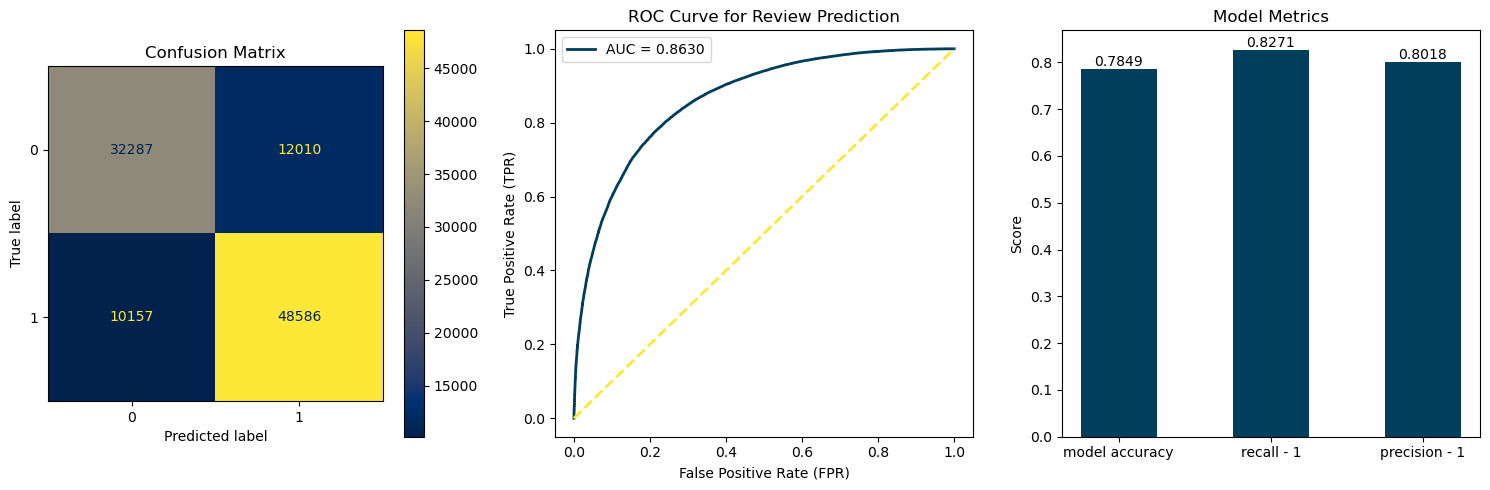

====                                                                      Model report:                                                                          ====
====                                                                   Log regression WO train                                                                       ====


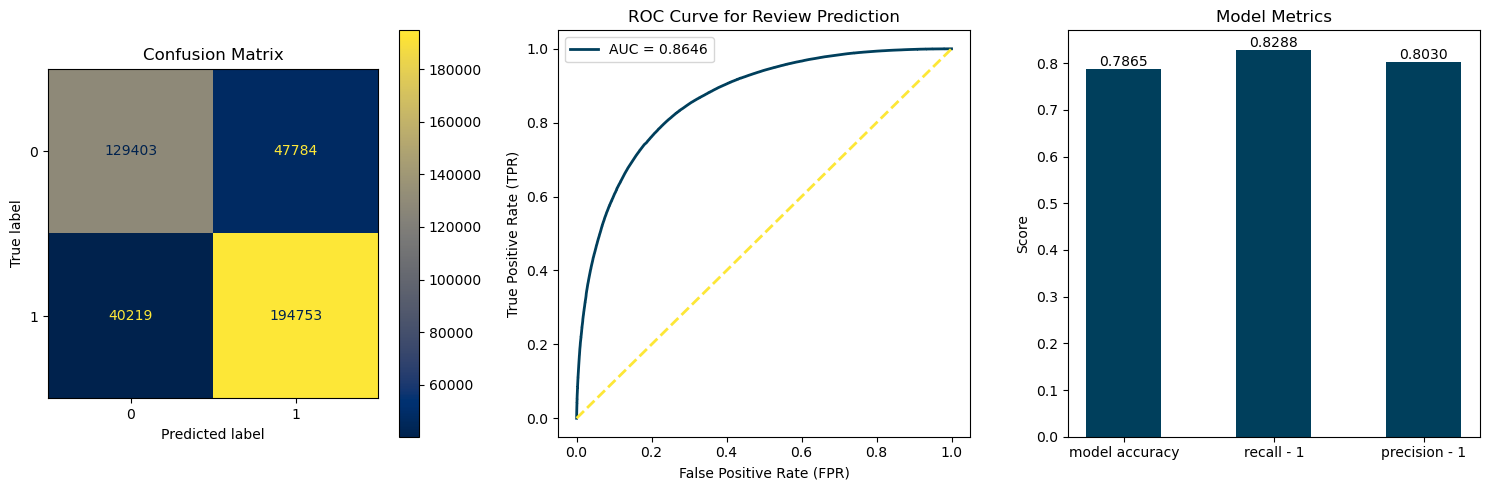

In [85]:
model_evaluation_report(y_test, X_test_df, logreg_model_wO,   'Log regression wO test')
model_evaluation_report(y_train, X_train_df, logreg_model_wO, 'Log regression WO train')


An attempt is made to improve the model by adjusting parameters The parameters to be changed and defined here are the cost function or its influence defined by c and the number of iterations in the calculation. Due to computing power, the number of iterations is set to 1000 and the model accuracy for different c_value is compared with each other

#### Hyperparameter tunning

In [86]:
c_value = np.array([0.001, 0.01, 0.1, 1, 10, 100,1000, 10000, 100_000])

In [87]:
# validation_scores = []
# train_scores = []

# for val in c_value:
#     logreg_model = LogisticRegression(C=val, max_iter= 1000, random_state= 123)
#     logreg_model.fit(X_train_df, y_train)

#     train_scores.append(logreg_model.score(X_train_df,y_train))
#     validation_scores.append(logreg_model.score(X_test_df,y_test))

We safe the validation lists after calculating the values

In [88]:
# joblib.dump(validation_scores, './models/validation_scores.pkl') 
# joblib.dump(train_scores, './models/train_scores.pkl')

Reload the validation lists:

In [89]:
validation_scores = joblib.load('./models/validation_scores.pkl')
train_scores = joblib.load('./models/train_scores.pkl')

We visualise the accuracies of the logistic model as a function of our c_values on a logarithmic scale from 0.001 to 100,000 

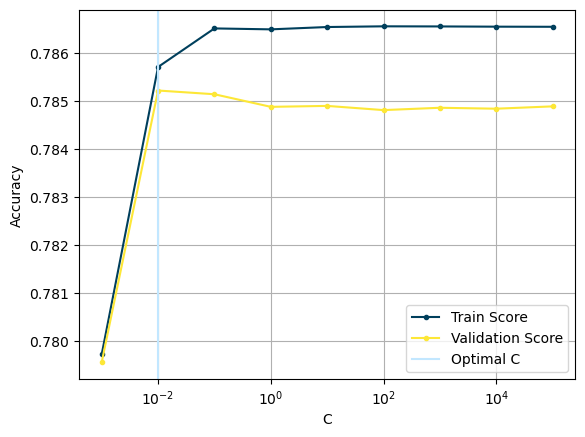

In [90]:
#plotting results
plt.figure()
plt.plot(c_value,train_scores, label='Train Score',marker='.', color='#003f5c')
plt.plot(c_value,validation_scores, label='Validation Score',marker='.',color='#FDE737')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.xscale("log")
plt.axvline(0.01, label = 'Optimal C', color = '#c2e7ff')
plt.grid()
plt.legend()
plt.show()

The optimum C is the point at which the accuracy of the training data and the validation data are close to each other and the model is not overfitted, i.e. the accuracy of the training modelling is significantly higher than that of the validation. After an optical analysis, C= 0.01 is selected as the best model and defined as a parameter.

The choosen C is C= 0.1

In [91]:
# logistic_Regression_model = LogisticRegression(C=0.1, max_iter=1000, random_state=123)

# logistic_Regression_model.fit(X_train_df, y_train)


In [92]:
# joblib.dump(logistic_Regression_model, './models/logistic_Regression_model.pkl')

In [93]:

logistic_Regression_model = joblib.load('./models/logistic_Regression_model.pkl')

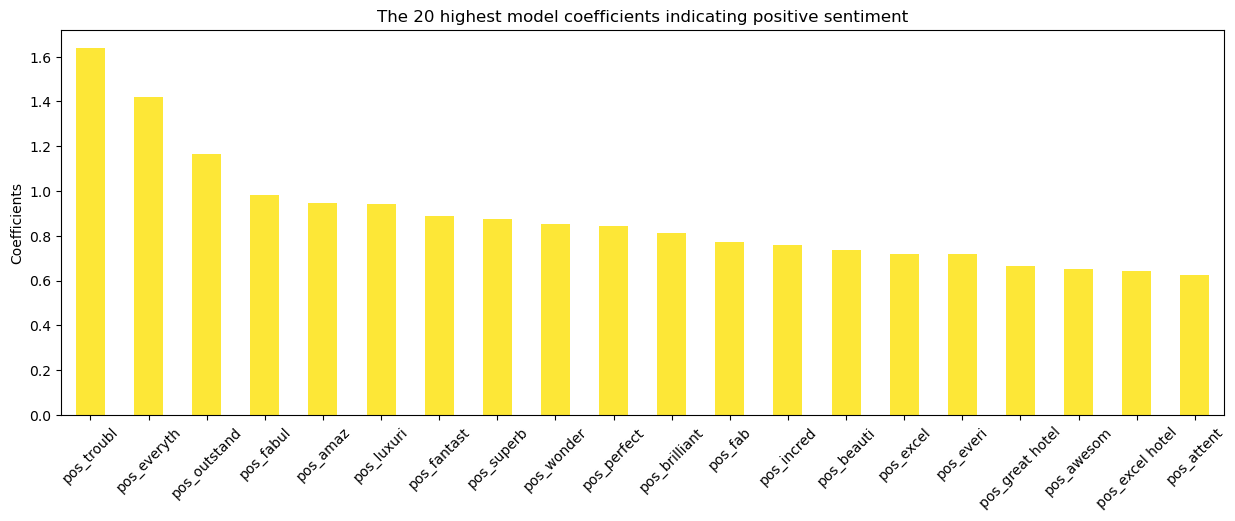

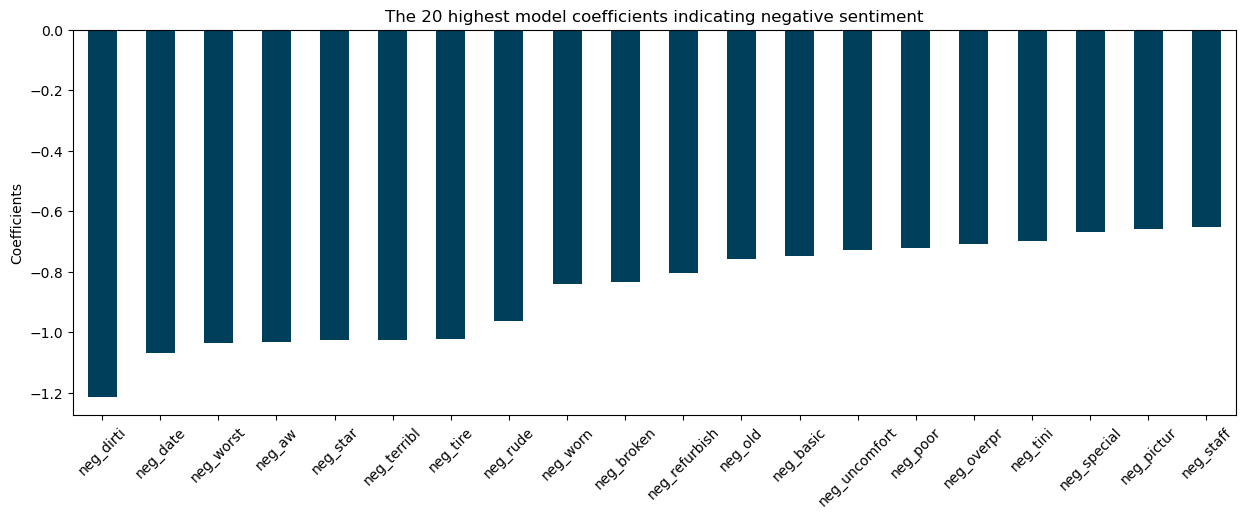

In [94]:

word_counts = pd.DataFrame(
    {
        "coefficients": logistic_Regression_model.coef_[0]},
        index=X_train_df.columns
)


# filtering of the positive or negative tokens 
positive_word_counts = word_counts[word_counts.index.str.startswith('pos_')]
negative_word_counts = word_counts[word_counts.index.str.startswith('neg_')]



positive_word_counts = positive_word_counts.sort_values("coefficients", ascending=False)
negative_word_counts = negative_word_counts.sort_values("coefficients", ascending= True)


positive_word_counts.head(20).plot(kind="bar", figsize=(15, 5),color='#FDE737', legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

negative_word_counts.head(20).plot(kind="bar", figsize=(15, 5),color='#003f5c', legend=False)
plt.title("The 20 highest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

 pos_troubl - beiden sind meiner Analyse nach zuerecht im entsprechenden Datensatz. 
filtered_tokens = [token for token in token_neg if 'perfect' in token] - ja, ist in token_neg


 Fragen, wie ich sichergehen kann, dass der Index noch funktionert - gerade in bezug auf pos_troubl.

In [95]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#### Logistic regression model evaluation 

====                                                                      Model report:                                                                          ====
====                                                                   Log regression test                                                                       ====


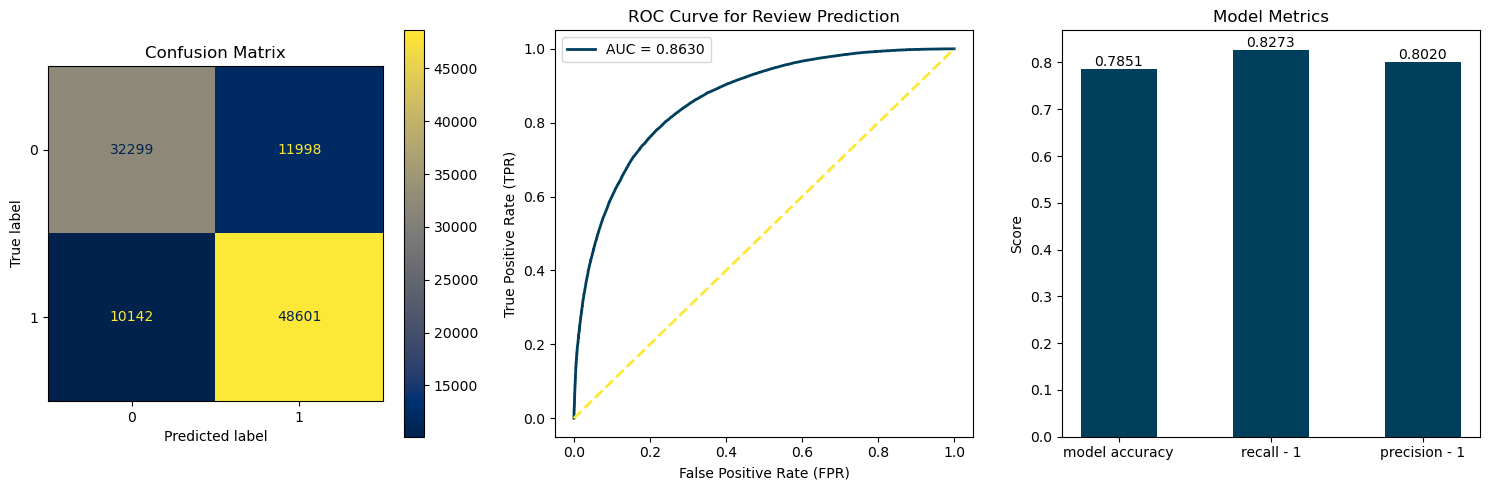

====                                                                      Model report:                                                                          ====
====                                                                   Log regression train                                                                       ====


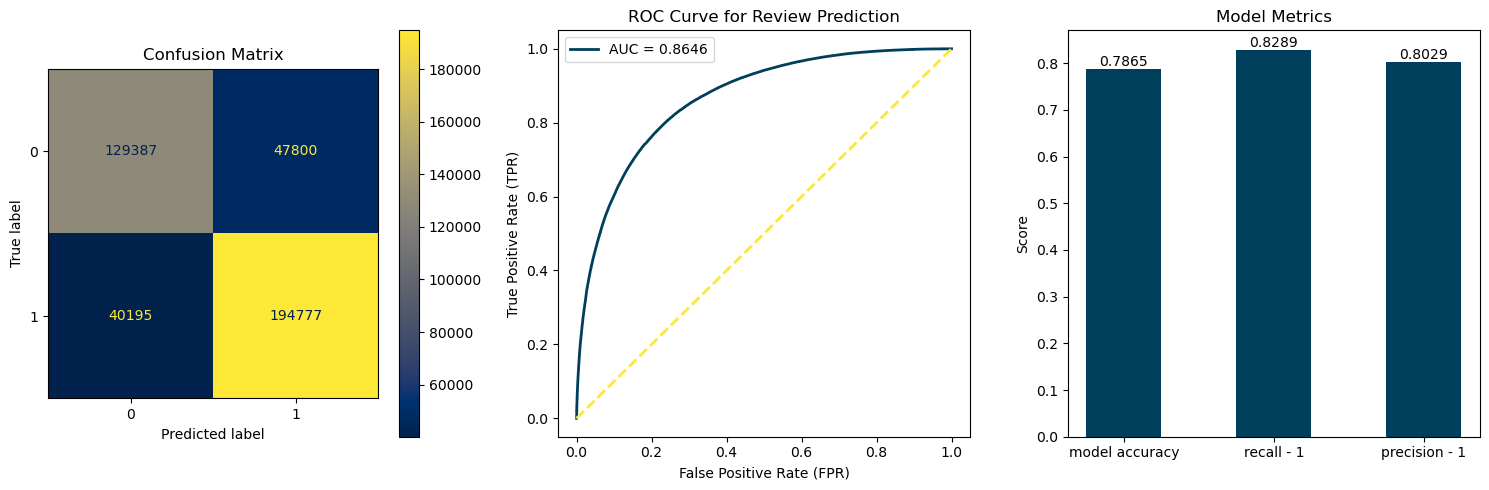

In [96]:
model_evaluation_report(y_test, X_test_df, logistic_Regression_model,   'Log regression test')
model_evaluation_report(y_train, X_train_df, logistic_Regression_model, 'Log regression train')

The performance of the model has improved very little. 

### 4.4 PCA with a decision tree classifier

In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [98]:
from tempfile import mkdtemp
cachedir = mkdtemp()

As with the Logistic Regression Model, we must first define the hyperparameters for the decision tree. In this case, this is done via a pipeline. The following steps are carried out: 

We apply a type of scaler to the data, in this case a principal component analysis, and then optimise the hyperparameters of our model, in this case a decision tree as a classification method.

In [99]:
estimators = [('scaler', PCA(n_components=20)),
              ('dt', DecisionTreeClassifier(random_state=23))]

pipe_tree = Pipeline(estimators, memory=cachedir)


We restrict the PCA to the first 20 components and define the following DecisionTree parameters as our hyperparameters: 

- max_depth --> the maximum depth that our tree may have before the classification is completed. This is used to prevent overfitting, a problem with decision trees.    
- min_sample_leaf --> the minimum number of objects that must remain after a node, this is also a protection against overfitting    
- criterion --> checks both the less complex computing method gini with the somewhat more precise entropy   

In [100]:
# Params for DecisionTreeClassifier()

max_depth = [2, 4, 6, 8, 10] 
min_sample_leaf = [1,2,3,4,5]
criterion = ['gini', 'entropy']


we pass the parameters to be selected to the pipeline with the corresponding parameter options

In [101]:
params = dict(
    dt__criterion = criterion,
    dt__max_depth = max_depth,
    dt__min_samples_leaf = min_sample_leaf
)

We initiate the model as a GridSearch - this means that the best combination is searched for between the - in this case 3 - parameters according to the criterion of accuracy. 

In [102]:
grid_search_model = GridSearchCV(pipe_tree, param_grid = params,cv=5, n_jobs=2, scoring='accuracy')

We use grid_search_model as our model and also use the fit method here to train the model. Now, however, the optimal combination of the parameters max_depth, min_sample_leaf and criterion is searched for in GridSearch. 

Beachte: das X_train ist mein X_remainder und es wird aufgeteilt in 4/5 Train und 1/5 Test 5 mal 


In [103]:
# grid_search_model.fit(X_train_df, y_train)

The process is correspondingly computationally complex. We have combinations of 2 parameter criterion, 5 parameter max_depth and 5 parameter min_sample_leaf.

So: 2*5*5 = 50 different combinations with which the model is fitted, and a K-fold cross validation is also carried out to ensure that each value from X_train is available as a validation in 5 iterations (cv=5) in order to minimise outliers and the influence of the individual splits. 


 with runtime: 51m 16.5s

In [104]:
# joblib.dump(grid_search_model, './models/grid_search_model.pkl')

In [105]:
grid_search_model = joblib.load('./models/grid_search_model.pkl')

In [106]:
best_pipe = grid_search_model.best_estimator_

In [107]:
print('Best scored Accuracy:', grid_search_model.best_score_);
print('Best DT Model:', grid_search_model.best_estimator_.get_params()['dt'])
print('Best DT Criterion:', grid_search_model.best_estimator_.get_params()['dt__criterion'])
print('Best DT min_samples_leaf:', grid_search_model.best_estimator_.get_params()['dt__min_samples_leaf'])
print('Best DT max_depth:', grid_search_model.best_estimator_.get_params()['dt__max_depth'])

Best scored Accuracy: 0.7452026999927419
Best DT Model: DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=23)
Best DT Criterion: gini
Best DT min_samples_leaf: 5
Best DT max_depth: 8


The min_sample_leaf parameter was set to 5. This is a predefined range limit of the parameter

In [108]:
print(grid_search_model.score(X_train_df,y_train))
print(grid_search_model.score(X_test_df,y_test))
print(best_pipe.score(X_train_df,y_train))

0.749256961512426
0.7453319099378882
0.749256961512426


====                                                                      Model report:                                                                          ====
====                                                                   Decision Tree test                                                                       ====


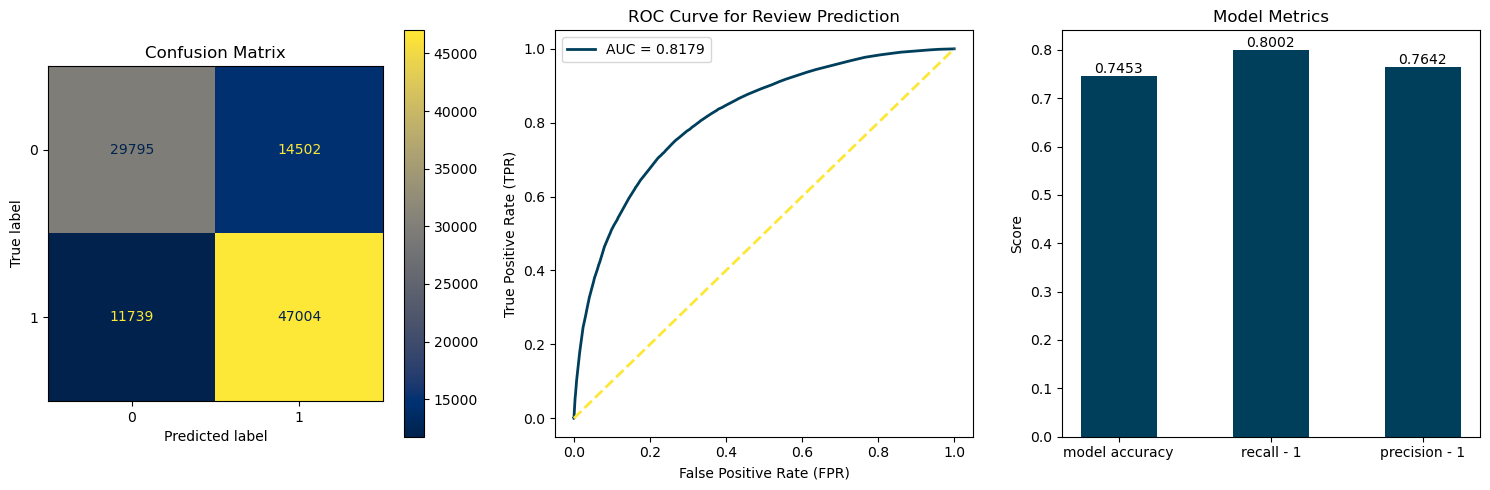

====                                                                      Model report:                                                                          ====
====                                                                   Decision Tree train                                                                       ====


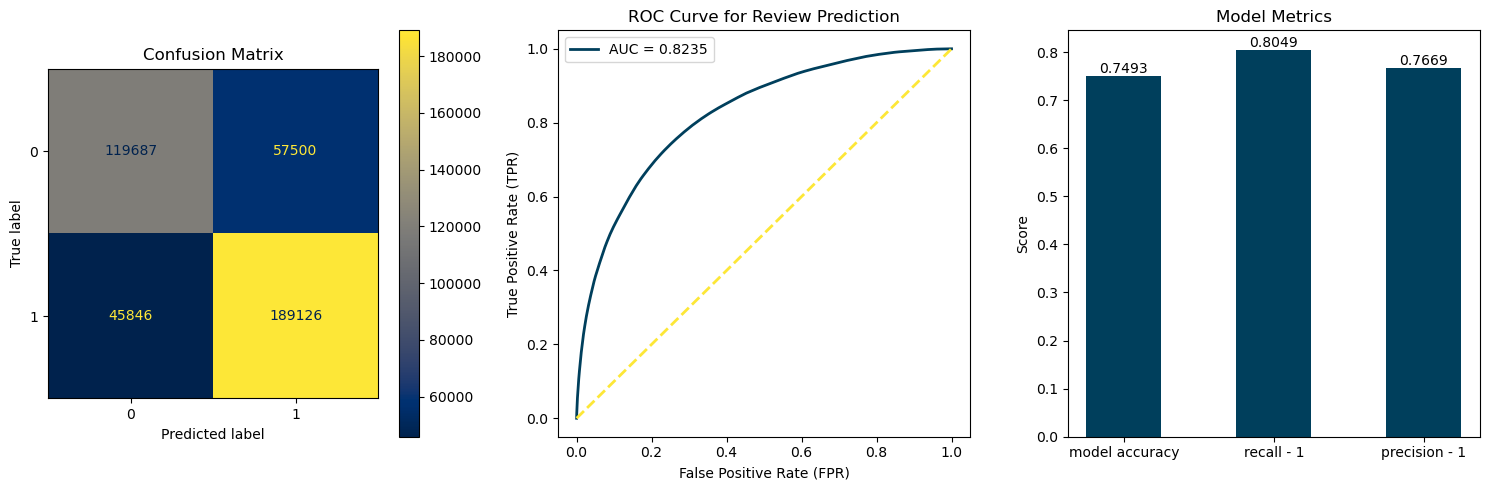

In [109]:
model_evaluation_report(y_test, X_test_df, grid_search_model, 'Decision Tree test')
model_evaluation_report(y_train, X_train_df, grid_search_model, 'Decision Tree train')

The parameter limits within GridSearch have been improved. In particular, a limit value - 5 - has been set for min_sample_leaf, so the limit for this parameter will be raised.

In [110]:
pipe_tree2 = Pipeline(estimators, memory=cachedir)

In [111]:
# We adjust the parameter ranges
max_depth2 = [ 6, 8, 10] 
min_sample_leaf2 = [3,5,7,9]
criterion2 = ['gini', 'entropy']

In [112]:
params2 = dict(
    dt__criterion = criterion2,
    dt__max_depth = max_depth2,
    dt__min_samples_leaf = min_sample_leaf2
)

In [113]:
grid_search_model2 = GridSearchCV(pipe_tree2, param_grid = params2, cv=5, n_jobs=2, scoring='accuracy')

In [114]:
# grid_search_model2.fit(X_train_df, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(memory='C:\\Users\\BMidd\\AppData\\Local\\Temp\\tmp_madgsik',
                                steps=[('scaler', PCA(n_components=20)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=23))]),
             n_jobs=2,
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [6, 8, 10],
                         'dt__min_samples_leaf': [3, 5, 7, 9]},
             scoring='accuracy')

In [115]:
# joblib.dump(grid_search_model2, './models/grid_search_model2.pkl')

['./models/grid_search_model2.pkl']

In [116]:
grid_search_model2 = joblib.load('./models/grid_search_model2.pkl')

In [122]:
print('Best scored Accuracy:', grid_search_model2.best_score_);
print('Best DT Model:', grid_search_model2.best_estimator_.get_params()['dt'])
print('Best DT Criterion:', grid_search_model2.best_estimator_.get_params()['dt__criterion'])
print('Best DT min_samples_leaf:', grid_search_model2.best_estimator_.get_params()['dt__min_samples_leaf'])
print('Best DT max_depth:', grid_search_model2.best_estimator_.get_params()['dt__max_depth'])

Best scored Accuracy: 0.7457583154103815
Best DT Model: DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=9,
                       random_state=23)
Best DT Criterion: entropy
Best DT min_samples_leaf: 9
Best DT max_depth: 10


====                                                                      Model report:                                                                          ====
====                                                                   Decision Tree test                                                                       ====


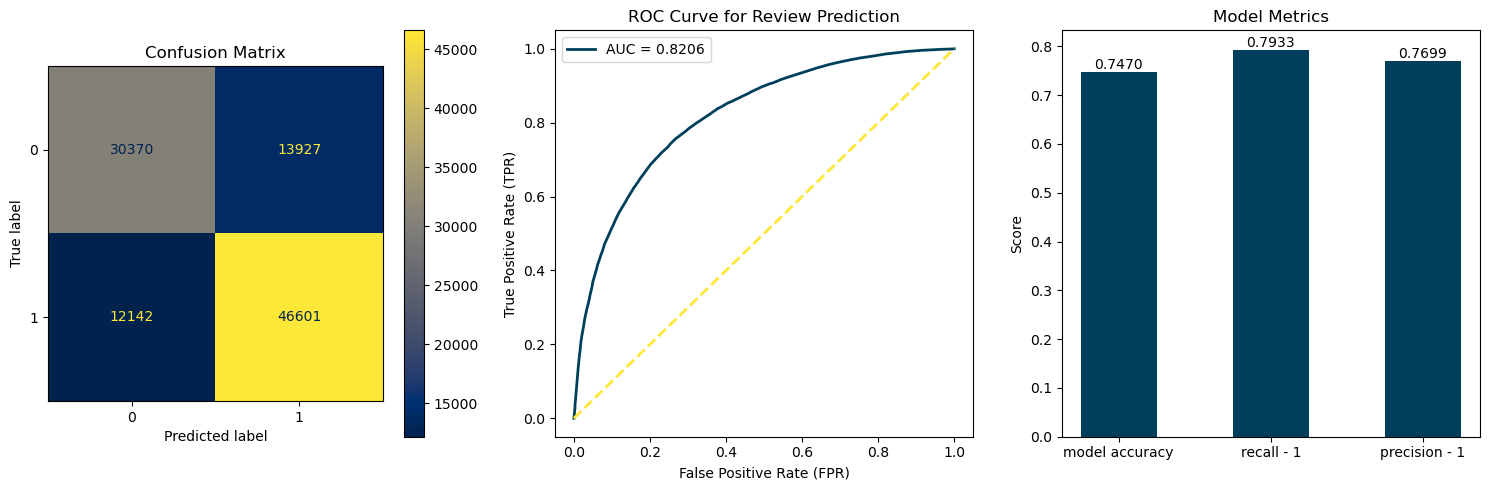

====                                                                      Model report:                                                                          ====
====                                                                   Decision Tree train                                                                       ====


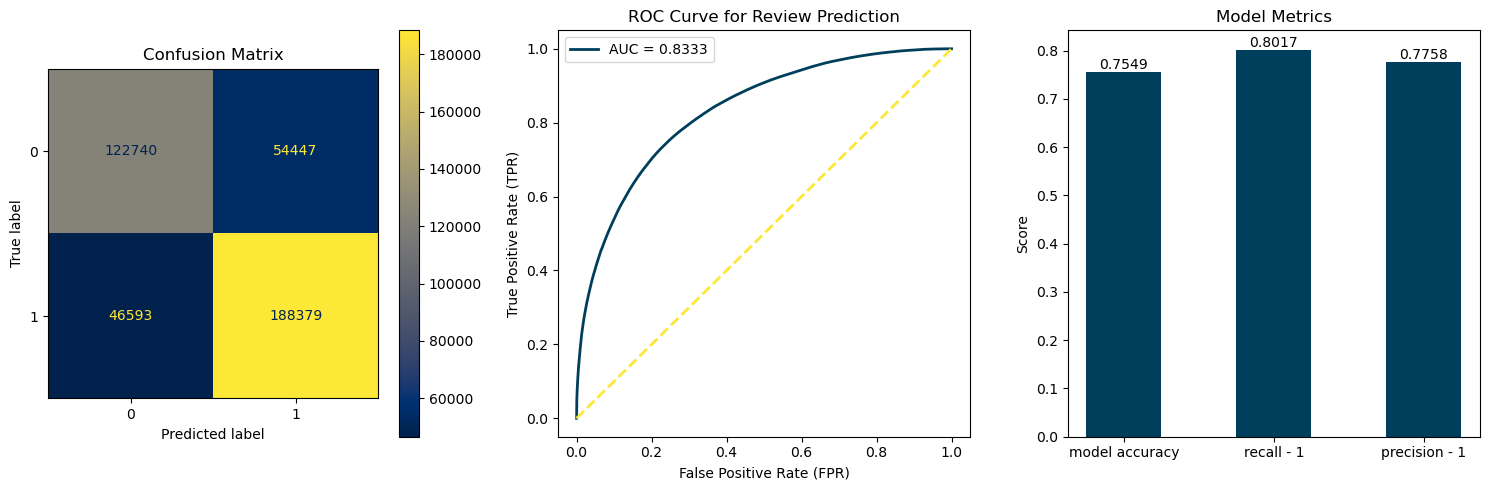

In [121]:
model_evaluation_report(y_test, X_test_df, grid_search_model2, 'Decision Tree test')
model_evaluation_report(y_train, X_train_df, grid_search_model2, 'Decision Tree train')

We see a further improvement, but the min_sample_leaf parameter is again set to its limit range - 9

In [123]:
max_depth3 = [10] 
min_sample_leaf3 = [11,13,15]
criterion3 = ['gini', 'entropy']

In [ ]:
params3 = dict(
    dt__criterion = criterion3,
    dt__max_depth = max_depth3,
    dt__min_samples_leaf = min_sample_leaf3
)

In [ ]:
grid_search_model3 = GridSearchCV(pipe_tree3, param_grid = params3, cv=5, n_jobs=2, scoring='accuracy')

In [ ]:
# grid_search_model3.fit(X_train_df, y_train)

In [ ]:
# joblib.dump(grid_search_model3, './models/grid_search_model3.pkl')

In [ ]:
grid_search_model3 = joblib.load('./models/grid_search_model3.pkl')

In [ ]:
print('Best scored Accuracy:', grid_search_model3.best_score_);
print('Best DT Model:', grid_search_model3.best_estimator_.get_params()['dt'])
print('Best DT Criterion:', grid_search_model3.best_estimator_.get_params()['dt__criterion'])
print('Best DT min_samples_leaf:', grid_search_model3.best_estimator_.get_params()['dt__min_samples_leaf'])
print('Best DT max_depth:', grid_search_model3.best_estimator_.get_params()['dt__max_depth'])

In [ ]:
model_evaluation_report(y_test, X_test_df, grid_search_model3, 'Decision Tree test')
model_evaluation_report(y_train, X_train_df, grid_search_model3, 'Decision Tree train')

#### Summary comparision:

| Model                                                       | Accuracy - Test data | Recall - Test data | Precision - Test data | Accuracy - Train data | Recall - Train data | Precision - Train data | Comments                                                   |
|-------------------------------------------------------------|----------------------|--------------------|-----------------------|-----------------------|---------------------|------------------------|------------------------------------------------------------|
| **Logistic Regression without Parameter optimazation**      | 0.7849               | 0.8271             | 0.8018                | 0.7865                | 0.8288              | 0.8030                 | basic logistic model                                       |
| **Logistic Regression with C optimization**                 | **0.7851**               | **0.8273**             | **0.8020**                | **0.7865**                | **0.8289**              | **0.8029**                 | **very little performance improvement, no over-/underfitting** |
| **Decision Tree Model with GridSearch for best parameters** | 0.7453               | 0.8002             | 0.7642                | 0.7493                | 0.8049              | 0.7669                 | no over-/underfitting                                      |
| **Decision Tree Model 2 with GridSearch for best parameters** | 0.7470               | 0.7933            | 0.7699                | 0.7549                | 0.8017              | 0.7758                 | no over-/underfitting                                      |
| **'Stupid ;)' model**                                       | 0.5701               | 1.0000             | 0.5701                | 0.5701                | 1.0000              | 0.5701                 | 'siz model iz stuipit'  


### 4.5 In-depth evaluation